In [ ]:
import torch
from transformers import DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

from transformers import BertTokenizer
from transformers import DistilBertTokenizer
import torch



# Análisis y Exploración de Datos (EDA)

## Carga de Datos y Preprocesamiento

### Cargar y Limpiar Datos

 **Pendiente** Descargar los archivos de github, dejarlos en una carpeta de staging y leerlos desde alli

In [ ]:

# Leer el archivo JSONL
file_path_train = 'train.jsonl'
file_path_test = 'test.jsonl'
file_path_val = 'validation.jsonl'
data = []

def read_jsonl(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

def explode_df(df):
  return df.explode(['messages', 'sender_labels', 'receiver_labels', 'absolute_message_index',
                          'relative_message_index', 'seasons', 'years', 'game_score', 'game_score_delta',
                          'speakers', 'receivers']).reindex()


# Convertir la lista de diccionarios en un DataFrame
df_train = pd.DataFrame(read_jsonl(file_path_train))
df_test = pd.DataFrame(read_jsonl(file_path_test))
df_val = pd.DataFrame(read_jsonl(file_path_val))

# Expandir las listas de mensajes, etiquetas y otros campos en filas individuales
df_expanded_train =explode_df(df_train)
df_expanded_test =explode_df(df_test)
df_expanded_val =explode_df(df_val)

# Mostrar las primeras filas del DataFrame expandido
df_expanded_train.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0,"[italy, germany]",1
0,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0,"[italy, germany]",1
0,👍,True,True,italy,germany,86,2,Spring,1901,3,0,"[italy, germany]",1
0,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0,"[italy, germany]",1
0,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,italy,germany,89,4,Spring,1901,3,0,"[italy, germany]",1


### Análisis Descriptivo

In [ ]:
## contar numero de mensajes totales
print("Total registros train: " + str(df_expanded_train.count()[0]))
print("Total registros test: " + str(df_expanded_test.count()[0]))
print("Total registros val: " + str(df_expanded_val.count()[0]))

Total registros train: 13132
Total registros test: 15873
Total registros val: 17289


In [ ]:
# Contar mensajes por juego
messages_per_game = df_expanded_train['game_id'].value_counts()
messages_per_game

game_id
2     3302
1     2619
3     1915
9     1611
7     1003
8      905
10     832
6      523
5      427
Name: count, dtype: int64

In [ ]:
# Jugadores más activos
active_speakers = df_expanded_train['speakers'].value_counts()
active_speakers

speakers
germany    2687
italy      2493
england    2304
austria    1827
russia     1317
france     1279
turkey     1225
Name: count, dtype: int64

In [ ]:
# Distribución de las puntuaciones
score_distribution = df_expanded_train['game_score'].fillna(0).astype(int).describe()
score_distribution

count    13137.000000
mean         5.324199
std          2.051748
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         17.000000
Name: game_score, dtype: float64

In [ ]:
df_expanded_train['sender_labels'].value_counts()

sender_labels
True     12541
False      591
Name: count, dtype: int64

In [ ]:
print(df_expanded_train['sender_labels'].unique())
print(df_expanded_train['receiver_labels'].unique())

[True False nan]
[True 'NOANNOTATION' False nan]


In [ ]:
df_expanded_train['sender_labels'].fillna('NOANNOTATION', inplace=True)
df_expanded_train['receiver_labels'].fillna('NOANNOTATION', inplace=True)

df_expanded_test['sender_labels'].fillna('NOANNOTATION', inplace=True)
df_expanded_test['receiver_labels'].fillna('NOANNOTATION', inplace=True)

df_expanded_val['sender_labels'].fillna('NOANNOTATION', inplace=True)
df_expanded_val['receiver_labels'].fillna('NOANNOTATION', inplace=True)


### Visualización de las Etiquetas

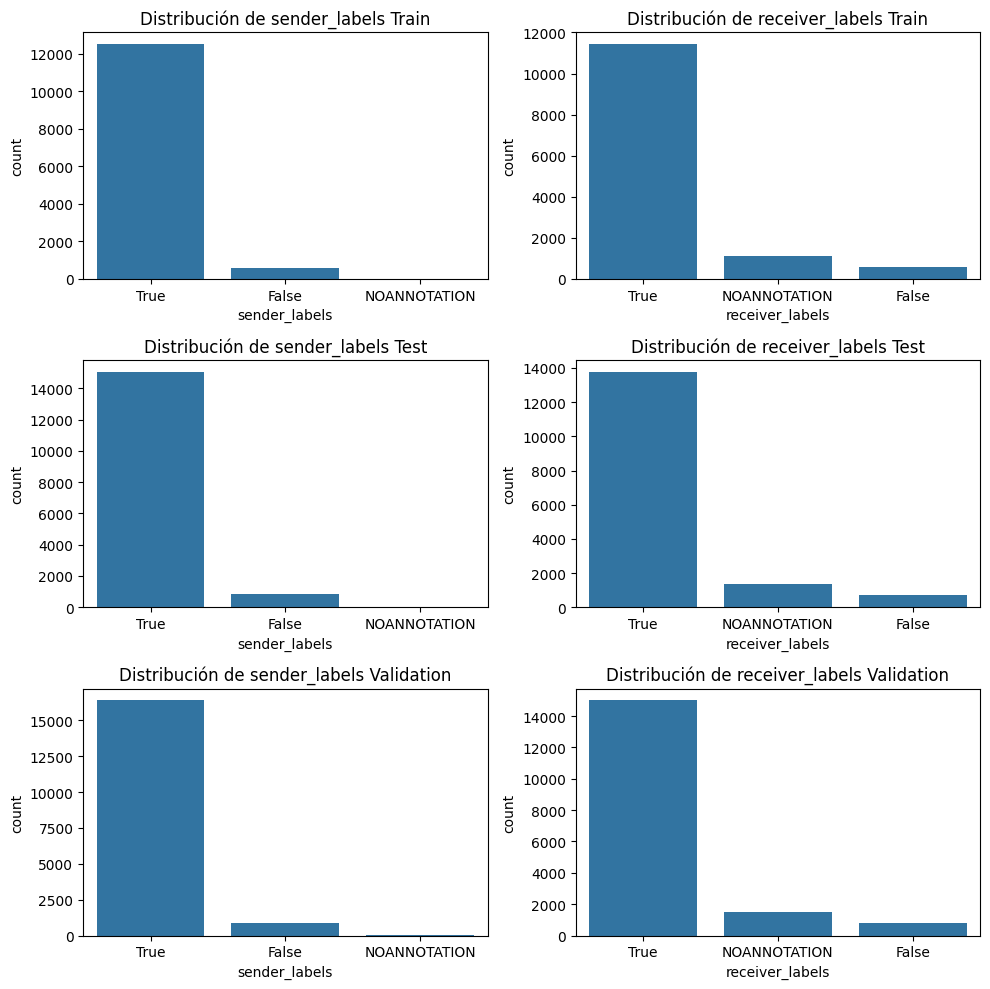

In [ ]:

# Create a figure and six subplots (axes)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Distribution of sender_labels train
sns.countplot(x='sender_labels', data=df_expanded_train, ax=axes[0, 0])  # Access axes correctly
axes[0, 0].set_title('Distribución de sender_labels Train')

# Distribution of receiver_labels train
sns.countplot(x='receiver_labels', data=df_expanded_train, ax=axes[0, 1])  # Access axes correctly
axes[0, 1].set_title('Distribución de receiver_labels Train')

# Distribution of sender_labels test
sns.countplot(x='sender_labels', data=df_expanded_test, ax=axes[1, 0])  # Access axes correctly
axes[1, 0].set_title('Distribución de sender_labels Test')

# Distribution of receiver_labels test
sns.countplot(x='receiver_labels', data=df_expanded_test, ax=axes[1, 1])  # Access axes correctly
axes[1, 1].set_title('Distribución de receiver_labels Test')

# Distribution of sender_labels validation
sns.countplot(x='sender_labels', data=df_expanded_val, ax=axes[2, 0])  # Access axes correctly
axes[2, 0].set_title('Distribución de sender_labels Validation')

# Distribution of receiver_labels validation
sns.countplot(x='receiver_labels', data=df_expanded_val, ax=axes[2, 1])  # Access axes correctly
axes[2, 1].set_title('Distribución de receiver_labels Validation')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

 **Pendiente** HACER NUBE DE PALABRAS DISCRIMINADO POR ETIQUETA TRUE Y FALSE, ES DECIR, CUALES SON LAS PALABRAS MAS DICHAS POR LOS RECEIVER TRUE, RECEIVER FALSE, SENDER TRUE Y SENDER FALSE

## Preprocesamiento y Preparación de Datos

Tokenizar las palabras de todos los insumos (train, test y validation)

In [ ]:

# Inicializar el tokenizador de BERT
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer_model = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokeneizer(df_expanded, tokenizer):

  # Ensure all messages are strings before tokenization
  df_expanded['messages'] = df_expanded['messages'].astype(str)
  # Convertir las etiquetas a formato booleano (eliminar etiquetas noannotation, son despreciables)
  #Se borran donde el sender sea 'NOANNOTATION', probar luego que hgacer con esa clase, hacerla -1 quizas
  df_expanded = df_expanded[(df_expanded['sender_labels'] != 'NOANNOTATION')]
  # Tokenizar los mensajes
  encoded_inputs = tokenizer(df_expanded['messages'].tolist(), padding=True, truncation=True, return_tensors='pt')
  labels = torch.tensor(df_expanded['sender_labels'].astype(int).tolist())
  return TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'], labels)


dataset_train = tokeneizer(df_expanded_train,tokenizer_model)
dataset_test = tokeneizer(df_expanded_test,tokenizer_model)
dataset_val = tokeneizer(df_expanded_val,tokenizer_model)

Geberar dataloader de cada uno de los insumos, train test y validation

In [ ]:

train_dataloader = DataLoader(dataset_train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=16, shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=16, shuffle=False)


### Train model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Train Loss: 0.18537833329730288, Test Loss: 0.18998472784220993, Accuracy: 0.9476469476469477, F1 Score: 0.9731198447355652
Epoch 2, Train Loss: 0.1692834418090049, Test Loss: 0.16957665738262317, Accuracy: 0.9476469476469477, F1 Score: 0.9731198447355652
Epoch 3, Train Loss: 0.1224618671999634, Test Loss: 0.11863872315828414, Accuracy: 0.9681849681849681, F1 Score: 0.9833536605465273
Epoch 4, Train Loss: 0.056905663963611464, Test Loss: 0.10603114047199337, Accuracy: 0.9749259749259749, F1 Score: 0.9868629522049116
Early stopping at epoch 4


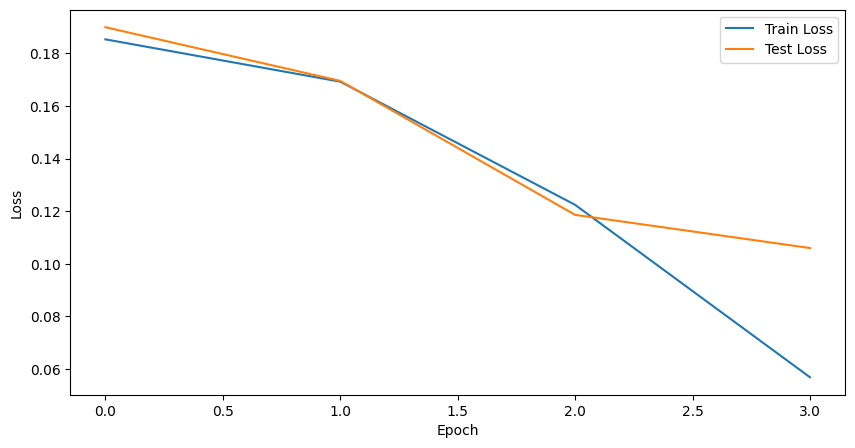

In [ ]:
# Mover el modelo a GPU si está disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Usar mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Mover el modelo a la GPU después de la inicialización
model.to(device)

# Definir el optimizador
optimizer = AdamW(model.parameters(), lr=3e-5)

# Definir el scheduler para ajuste de la tasa de aprendizaje
num_training_steps = len(train_dataloader) * 4  # Número de épocas * tamaño del dataloader
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Función de entrenamiento
def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]  # Mover los datos a GPU

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # Usar autocast para mixed precision
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# Función de evaluación
def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]  # Mover los datos a GPU

            with torch.cuda.amp.autocast():  # Usar autocast para mixed precision
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                total_loss += outputs.loss.item()
                preds.extend(torch.argmax(outputs.logits, dim=1).tolist())
                true_labels.extend(labels.tolist())
    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    avg_loss = total_loss / len(dataloader)
    return accuracy, f1, avg_loss

# Entrenar el modelo y evaluar
train_losses = []
test_accuracies = []
test_f1_scores = []
test_losses = []

best_diff = np.inf
early_stop_patience = 2
epochs_no_improve = 0


for epoch in range(10):
    train_loss = train(model, train_dataloader, optimizer, scheduler)
    train_losses.append(train_loss)

    accuracy, f1, test_loss = evaluate(model, test_dataloader)
    test_accuracies.append(accuracy)
    test_f1_scores.append(f1)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}, Accuracy: {accuracy}, F1 Score: {f1}')

    # Early stopping basado en la diferencia entre train loss y test loss
    current_diff = abs(train_loss - test_loss)

    if current_diff < best_diff:
        best_diff = current_diff
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stop_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test model

In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score

# Función de evaluación
def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch  # Unpack all three tensors
            outputs = model(input_ids.to(device), attention_mask=attention_mask.to(device)) # Move inputs to device
            preds.extend(torch.argmax(outputs.logits, dim=1).tolist())
            true_labels.extend(labels.tolist())
    return accuracy_score(true_labels, preds), f1_score(true_labels, preds)

# Evaluar el modelo
accuracy, f1 = evaluate(model, test_dataloader)
print(f'Accuracy: {accuracy}, F1 Score: {f1}')

Accuracy: 0.9749259749259749, F1 Score: 0.9868629522049116


### Validate model

In [ ]:
# validar el modelo
accuracy, f1 = evaluate(model, val_dataloader)
print(f'Accuracy: {accuracy}, F1 Score: {f1}')

Accuracy: 0.9724102030192608, F1 Score: 0.9855642647459372
